In [89]:
%matplotlib inline 

import os
import json 
import time
import pickle
import pandas as pd 
import seaborn as sns

from sklearn.datasets.base import Bunch
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.exceptions import NotFittedError
from sklearn import metrics

from sklearn.model_selection import KFold #ensure allows for randomization
from sklearn.model_selection import train_test_split as tts #drop this if using KFold


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced.csv"))
DATA = pd.read_csv(filepath, low_memory=False)

DATA['locality_type'] = None
cloc = DATA.columns.get_loc('locality_type')
i = 0
for x in DATA['msamd_name'].isna():
    if x == True:
        DATA.iat[i, cloc]= 0
        
    else: 
        DATA.iat[i, cloc]= 1
        
    i+=1
        
DATA['locality_type'] = DATA['locality_type'].astype('int64')

DATA['action_taken'] = DATA.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)

DATA['applicant_income_000s'].fillna(DATA.hud_median_family_income.median(), inplace=True)

remove = ['purchaser_type_name',
        'preapproval_name',
        'rate_spread', 
        'sequence_number', 
        'respondent_id',
        'state_name',
        'state_abbr',
        'county_name',
        'edit_status_name', 
        'denial_reason_name_3', 
        'denial_reason_name_2', 
        'denial_reason_name_1', 
        'co_applicant_race_name_5', 
        'co_applicant_race_name_4', 
        'co_applicant_race_name_3', 
        'co_applicant_race_name_2',
        'census_tract_number',
        'application_date_indicator', 
        'applicant_race_name_5', 
        'applicant_race_name_4', 
        'applicant_race_name_3', 
        'applicant_race_name_2', 
        'agency_name',
        'action_taken_name', 
        'msamd_name']

int_float = ['tract_to_msamd_income', 
        'population', 
        'minority_population', 
        'number_of_owner_occupied_units', 
        'number_of_1_to_4_family_units', 
        'loan_amount_000s', 
        'hud_median_family_income', 
        'applicant_income_000s',
        'locality_type']

categorical = ['property_type_name', 
        'owner_occupancy_name', 
        'loan_type_name', 
        'loan_purpose_name',
        'lien_status_name', 
        'hoepa_status_name', 
        'co_applicant_sex_name',
        'co_applicant_race_name_1', 
        'co_applicant_ethnicity_name', 
        'as_of_year',
        'applicant_sex_name', 
        'applicant_race_name_1',
        'applicant_ethnicity_name', 
        'agency_abbr']

DATA = DATA.drop(DATA.columns[0], axis=1)
DATA = DATA.drop(remove, axis=1)
X = DATA[[col for col in DATA.columns if col != 'action_taken']]
y = DATA['action_taken']

filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced_formatted.csv"))
DATA.to_csv(filepath, index=False)

In [20]:
print(DATA.shape)
print(X.shape)
DATA.describe(include='all')

(50000, 24)
(50000, 23)


tract_to_msamd_income    population  minority_population  \
count            50000.000000  50000.000000         50000.000000   
unique                    NaN           NaN                  NaN   
top                       NaN           NaN                  NaN   
freq                      NaN           NaN                  NaN   
mean               110.760058   5633.718300            33.533193   
std                 40.470068   3012.190961            27.023663   
min                  0.000000     87.000000             0.000000   
25%                 84.839996   3826.000000            11.530000   
50%                105.470001   5120.000000            25.160000   
75%                130.552502   6726.000000            50.049999   
max                468.000000  53812.000000           100.000000   

        number_of_owner_occupied_units  number_of_1_to_4_family_units  \
count                      50000.00000                   50000.000000   
unique                             NaN                            NaN   
top                                NaN                            NaN   
freq                               NaN                            NaN   
mean                        1434.35328                    1977.296320   
std                          833.92800                    1033.910772   
min                            0.00000                       0.000000   
25%                          909.00000                    1332.000000   
50%                         1301.00000                    1808.000000   
75%                         1782.00000                    2397.000000   
max                        19529.00000                   25391.000000   

        loan_amount_000s  hud_median_family_income  applicant_income_000s  \
count       50000.000000              50000.000000           50000.000000   
unique               NaN                       NaN                    NaN   
top                  NaN                       NaN                    NaN   
freq                 NaN                       NaN                    NaN   
mean          228.458040              70502.446000            7906.332320   
std           591.345455              15045.781898           21643.441935   
min             1.000000              15800.000000               1.000000   
25%            97.000000              61100.000000              50.000000   
50%           172.000000              67900.000000              82.000000   
75%           279.000000              76300.000000             150.000000   
max         68000.000000             131500.000000          132000.000000   

                                       property_type_name  \
count                                               50000   
unique                                                  3   
top     One-to-four family dwelling (other than manufa...   
freq                                                47112   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                          owner_occupancy_name  ... co_applicant_sex_name  \
count                                    50000  ...                 50000   
unique                                       3  ...                     5   
top     Owner-occupied as a principal dwelling  ...       No co-applicant   
freq                                     45053  ...                 27495   
mean                                       NaN  ...                   NaN   
std                                        NaN  ...                   NaN   
min                                        NaN  ...                   NaN   
25%                                     

Because the CSV data doesn't have a header row, I had to supply the names directly to the `pd.read_csv` function. To get these names, I manually constructed the list by reading the `adult.names` file. In the future, we'll store these names as a machine readable JSON file so that we don't have to manuually construct it. 

By glancing at the first 5 rows of the data, we can see that we have primarily categorical data. Our target, `data.income` is also currently constructed as a categorical field. Unfortunately, with categorical fields, we don't have a lot of visualization options (quite yet). However, it would be interesting to see the frequencies of each class, relative to the target of our classifier. To do this, we can use Seaborn's `countplot` function to count the occurrences of each data point. Let's take a look at the counts of `data.occupation` and `data.education` &mdash; two likely predictors of income in the census data:

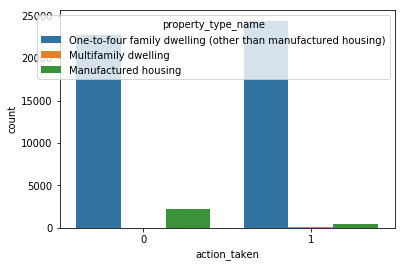

In [10]:
sns.countplot(x='action_taken', hue='property_type_name', data=DATA,)

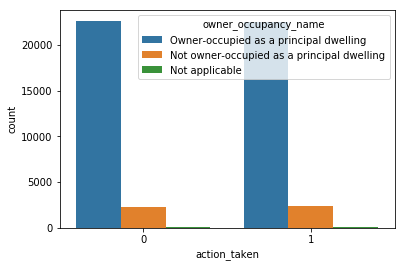

In [11]:
sns.countplot(x='action_taken', hue='owner_occupancy_name', data=DATA,)

In [ ]:
meta = {
    'target_names': [str(yi) for yi in y.unique()],
    'feature_names': list(X.columns),
    'categorical_features': {
        column: list(X[column].unique())
        for column in X.columns
        if X[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
     json.dump(meta, f, indent=2)

This code creates a `meta.json` file by inspecting the data frame that we have constructued. The `target_names` column, is just the two unique values in the `data.income` series; by using the `pd.Series.unique` method - we're guarenteed to spot data errors if there are more or less than two values. The `feature_names` is simply the names of all the columns. 

Then we get tricky &mdash; we want to store the possible values of each categorical field for lookup later, but how do we know which columns are categorical and which are not? Luckily, Pandas has already done an analysis for us, and has stored the column data type, `data[column].dtype`, as either `int64` or `object`. Here I am using a dictionary comprehension to create a dictionary whose keys are the categorical columns, determined by checking the object type and comparing with `object`, and whose values are a list of unique values for that field. 

Now that we have everything we need stored on disk, we can create a `load_data` function, which will allow us to load the training and test datasets appropriately from disk and store them in a `Bunch`: 

In [29]:
def load_data(root=os.getcwd()):
    # Construct the `Bunch` for the HMDA dataset
    filenames     = {
        'meta': os.path.join(root, 'data','meta.json'),
        'rdme': os.path.join("..",'readme.md'),
        'data': os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced_formatted.csv")),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = pd.read_csv(filenames['data'], low_memory=False)

    # Extract the target from the data
    data = dataset[[col for col in DATA.columns if col != 'action_taken']]
    target = dataset['action_taken']

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        categorical_features = meta['categorical_features'], 
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)

(50000, 23)


The primary work of the `load_data` function is to locate the appropriate files on disk, given a root directory that's passed in as an argument (if you saved your data in a different directory, you can modify the root to have it look in the right place). The meta data is included with the bunch, and is also used split the train and test datasets into `data` and `target` variables appropriately, such that we can pass them correctly to the Scikit-Learn `fit` and `predict` estimator methods. 

## Feature Extraction 

Now that our data management workflow is structured a bit more like Scikit-Learn, we can start to use our data to fit models. Unfortunately, the categorical values themselves are not useful for machine learning; we need a single instance table that contains _numeric values_. In order to extract this from the dataset, we'll have to use Scikit-Learn transformers to transform our input dataset into something that can be fit to a model. In particular, we'll have to do the following:

- encode the categorical labels as numeric data 
- impute missing values with data (or remove)

We will explore how to apply these transformations to our dataset, then we will create a feature extraction pipeline that we can use to build a model from the raw input data. This pipeline will apply both the imputer and the label encoders directly in front of our classifier, so that we can ensure that features are extracted appropriately in both the training and test datasets.  

### Label Encoding 

Our first step is to get our data out of the object data type land and into a numeric type, since nearly all operations we'd like to apply to our data are going to rely on numeric types. Luckily, Sckit-Learn does provide a transformer for converting categorical labels into numeric integers: [`sklearn.preprocessing.LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Unfortunately it can only transform a single vector at a time, so we'll have to adapt it in order to apply it to multiple columns. 

Like all Scikit-Learn transformers, the `LabelEncoder` has `fit` and `transform` methods (as well as a special all-in-one, `fit_transform` method) that can be used for stateful transformation of a dataset. In the case of the `LabelEncoder`, the `fit` method discovers all unique elements in the given vector, orders them lexicographically, and assigns them an integer value. These values are actually the indices of the elements inside the `LabelEncoder.classes_` attribute, which can also be used to do a reverse lookup of the class name from the integer value. 

For example, if we were to encode the `gender` column of our dataset as follows:

Obviously this is very useful for a single column, and in fact the `LabelEncoder` really was intended to encode the target variable, not necessarily categorical data expected by the classifiers.

**Note:** Unfortunately, it was at this point that I realized the values all had a space in front of them. I'll address what I might have done about this in the conclusion. 

In order to create a multicolumn LabelEncoder, we'll have to extend the `TransformerMixin` in Scikit-Learn to create a transformer class of our own, then provide `fit` and `transform` methods that wrap individual `LabelEncoders` for our columns. My code, inspired by the StackOverflow post &ldquo;[Label encoding across multiple columns in scikit-learn](http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn)&rdquo;, is as follows:

In [32]:
class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
            
        return output

encoder = EncodeCategorical(dataset.categorical_features.keys())
data = encoder.fit_transform(dataset.data)

data

tract_to_msamd_income  population  minority_population  \
0                  96.660004       13024            85.070000   
1                  58.459999        8397            44.180000   
2                 126.860001        3171            27.280001   
3                  82.089996        5227            93.250000   
4                  74.410004        5343            15.480000   
5                  92.169998        4924            32.029999   
6                 114.910004        5562            15.550000   
7                  68.169998        6511            37.459999   
8                 107.050003        3711             4.720000   
9                 276.100006        2753             7.340000   
10                108.199997        2714             5.340000   
11                 67.919998        5337            78.919998   
12                118.860001        8719            86.900002   
13                142.330002       20033             3.550000   
14                112.900002        4007             1.220000   
15                 75.440002       11397            66.820000   
16                111.370003        6529            15.520000   
17                 80.290001        6450            54.570000   
18                123.620003        4810            18.090000   
19                 59.000000        2596            63.830002   
20                131.690002        3993            29.950001   
21                100.669998        3120            19.129999   
22                112.330002        3647            44.310001   
23                 85.570000        5752            53.220001   
24                161.809998        7269            27.170000   
25                241.029999        3710             7.630000   
26                149.580002        4121             4.460000   
27                136.830002        5207            36.139999   
28                101.699997        4828             4.270000   
29                149.910004        4329            64.430000   
...                      ...         ...                  ...   
49970              65.930000        7821            91.019997   
49971             153.130005        2719             6.470000   
49972             101.459999        4090             1.980000   
49973              86.000000        3227             6.910000   
49974              97.900002        6909             3.790000   
49975              47.610001        3259            24.459999   
49976              91.300003        5944            34.720001   
49977              74.650002        2482            98.150002   
49978             100.059998        1797             8.460000   
49979              94.889999        4923            10.930000   
49980             100.389999        5146            25.299999   
49981              98.559998       35527            21.920000   
49982             126.449997        6969            12.460000   
49983              76.849998        4410            80.519997   
49984             114.389999        6808            40.290001   
49985             108.480003        1792             2.290000   
49986              61.130001        2825            96.070000   
49987             126.150002       11178            19.120001   
49988             130.529999        6392             6.490000   
49989             119.269997        3808            26.730000   
49990              36.240002        3490            99.510002   
49991             124.290001        4078            28.000000   
49992              93.889999        6516            90.290001   
49993              56.360001        3437            23.889999   
49994             131.559998        6428            73.410004   
49995              95.459999        4007             6.610000   
49996             117.570000        6398            40.840000   
49997             102.430000        1684            29.930000   
49998             107.459999        2304            42.099998   
49999              99.389999        5143  

In [33]:
for col, lec in encoder.encoders.items():
    try:
        print(lec.classes_)
    except:
        pass

['Manufactured housing' 'Multifamily dwelling'
 'One-to-four family dwelling (other than manufactured housing)']
['Not applicable' 'Not owner-occupied as a principal dwelling'
 'Owner-occupied as a principal dwelling']
['Conventional' 'FHA-insured' 'FSA/RHS-guaranteed' 'VA-guaranteed']
['Home improvement' 'Home purchase' 'Refinancing']
['Not applicable' 'Not secured by a lien' 'Secured by a first lien'
 'Secured by a subordinate lien']
['HOEPA loan' 'Not a HOEPA loan']
['Female'
 'Information not provided by applicant in mail, Internet, or telephone application'
 'Male' 'No co-applicant' 'Not applicable']
['American Indian or Alaska Native' 'Asian' 'Black or African American'
 'Information not provided by applicant in mail, Internet, or telephone application'
 'Native Hawaiian or Other Pacific Islander' 'No co-applicant'
 'Not applicable' 'White']
['Hispanic or Latino'
 'Information not provided by applicant in mail, Internet, or telephone application'
 'No co-applicant' 'Not Hispanic 

Our custom imputer, like the `EncodeCategorical` transformer takes a set of columns to perform imputation on. In this case we only wrap a single `Imputer` as the `Imputer` is multicolumn &mdash; all that's required is to ensure that the correct columns are transformed. I inspected the encoders and found only three columns that had missing values in them, and passed them directly into the customer imputer. 

I had chosen to do the label encoding first, assuming that because the `Imputer` required numeric values, I'd be able to do the parsing in advance. However, after requiring a custom imputer, I'd say that it's probably best to deal with the missing values early, when they're still a specific value, rather than take a chance. 

## Model Build 

Now that we've finally acheived our feature extraction, we can continue on to the model build phase. To create our classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. Our pipeline is as follows:

In [62]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

In [90]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, int_float),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
'''clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])'''

"clf = Pipeline(steps=[('preprocessor', preprocessor),\n                      ('classifier', LogisticRegression(solver='lbfgs'))])"

In [91]:
preprocessor.fit_transform(dataset.data, dataset.target).shape

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


(50000, 68)

In [86]:
# figure out the indices of the categorical columns 
categorical_indexes = [
    list(dataset.data.columns).index(key) for key in dataset.categorical_features.keys()
]


hmda = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('onehot', OneHotEncoder(categorical_features=categorical_indexes))
    ])

In [87]:
extractor.fit_transform(dataset.data, dataset.target).shape

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


(50000, 68)

In [76]:
X = dataset.data
y = dataset.target

In [92]:
def fit_and_evaluate(X, y, model, label, **kwargs):

    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True, random_state=1)
    
    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        '''estimator = Pipeline([
        ('extract', clone(extractor)),
        ('model', model(**kwargs))
        ])'''
        estimator = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model(**kwargs))])
        
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))
    

In [93]:
fit_and_evaluate(X, y, RandomForestClassifier, "HMDA Random Forest Classifier", n_estimators=100)

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were a

Build and Validation of HMDA Random Forest Classifier took 293.235 seconds
Validation scores are as follows:

precision    0.723938
recall       0.721880
accuracy     0.721880
f1           0.721271
dtype: float64


ValueError: could not convert string to float: 'One-to-four family dwelling (other than manufactured housing)'

In [38]:
##Delete this cell
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# we need to encode our target data as well. 
#yencode = LabelEncoder().fit(dataset.target)

# figure out the indices of the categorical columns 
categorical_indexes = [
    list(dataset.data.columns).index(key) for key in dataset.categorical_features.keys()
]

# construct the pipeline 
hmda = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('onehot', OneHotEncoder(categorical_features=categorical_indexes)),
        ('classifier', LogisticRegression())
    ])

# fit the pipeline 
hmda.fit(dataset.data, dataset.target)
#hmda.fit(dataset.data, yencode.transform(dataset.target))

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

Pipeline(memory=None,
     steps=[('encoder', EncodeCategorical(columns=['property_type_name', 'owner_occupancy_name', 'loan_type_name', 'loan_purpose_name', 'lien_status_name', 'hoepa_status_name', 'co_applicant_sex_name', 'co_applicant_race_name_1', 'co_applicant_ethnicity_name', 'applicant_sex_name', 'applicant_race_name_1...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

The pipeline first passes data through our encoder, then to the imputer, and finally to our classifier. In this case, I have chosen a `LogisticRegression`, a regularized linear model that is used to estimate a categorical dependent variable, much like the binary target we have in this case. We can then evaluate the model on the test data set using the same exact pipeline. 

In [ ]:
from sklearn.metrics import classification_report 

# encode test targets, and strip traililng '.' 
y_true = dataset.target_test

# use the model to get the predicted value
y_pred = hmda.predict(dataset.data_test)

# execute classification report 
print(classification_report(y_true, y_pred, target_names=dataset.target_names))

As part of the process in encoding the target for the test data, I discovered that the classes in the test data set had a `"."` appended to the end of the class name, which I had to strip in order for the encoder to work! However, once done, I could predict the y values using the test dataset, passing the predicted and true values to the classifier report. 

The classifier I built does an ok job, with an F1 score of 0.77, nothing to sneer at. However, it is possible that an SVM, a Naive Bayes, or a k nearest neighbor model would do better. It is easy to construct new models using the pipeline approach that we prepared before, and I would encourage you to try it out! Furthermore, a grid search or feature analysis may lead to a higher scoring model than the one we quickly put together. Luckily, now that we've sorted out all the pipeline issues, we can get to work on inspecting and improving the model! 

The last step is to save our model to disk for reuse later, with the `pickle` module:

In [ ]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(census)

You should also dump meta information about the date and time your model was built, who built the model, etc. But we'll skip that step here, since this post serves as a guide. 

## Model Operation 

Now it's time to explore how to use the model. To do this, we'll create a simple function that gathers input from the user on the command line, and returns a prediction with the classifier model. Moreover, this function will load the pickled model into memory to ensure the latest and greatest saved model is what's being used. 

In [ ]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=dataset):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            val = " " + input("enter {} >".format(column))
            if valid and val not in valid:
                print("Not valid, choose one of {}".format(valid))
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)